In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [9]:
train_df = pd.read_csv("https://raw.githubusercontent.com/bournenadia26/cs131/refs/heads/main/train_midterm.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/bournenadia26/cs131/refs/heads/main/test_midterm.csv")

# from df to numpy arr
X_train = train_df.drop(columns=['label']).to_numpy()
y_train = train_df['label'].to_numpy()
X_test = test_df.drop(columns=['label']).to_numpy()
y_test = test_df['label'].to_numpy()

In [19]:
# MLP
def build(width, depth):
    layers = [
        tf.keras.layers.Input(shape=(X_train.shape[1],))  # Input layer
    ]

    for i in range(depth):
        layers.append(tf.keras.layers.Dense(width, activation='relu'))  # Hidden layers

    layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))  # Output layer

    model = tf.keras.models.Sequential(
        layers=layers,
        name='Multi-layer_Perceptron'
    )

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

width_vals = [32,128]  # values to test
depth_vals = [2,4]
avg_mlp_loss_list = []  # save for later
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

final_mlp_loss_list = [] #to graph

for width in width_vals:  # to test values
  for depth in depth_vals:

    mlp_val_loss_list = []
    mlp_train_loss_list = []

    print("------------------------------------------------")
    print(f"\nWidth: {width}, Depth: {depth}\n")
    print("------------------------------------------------\n")

    for train_idx, val_idx in kfold.split(X_train):

      model = build(width,depth)  # run our build function

      # edited from provided way to train model
      history = model.fit(
        X_train[train_idx], # X
        y_train[train_idx], # y
        validation_data=(X_train[val_idx], y_train[val_idx]), # give val data specifically
        epochs=15,
        batch_size=8,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
      )

      #save final loss of iteration
      val_loss = history.history['val_loss'][-1]
      train_loss = history.history['loss'][-1]
      print(f"Final Validation Loss: {val_loss}")
      print(f"Final Train Loss: {train_loss}\n")
      mlp_val_loss_list.append(val_loss)
      mlp_train_loss_list.append(train_loss)

      final_mlp_loss_list.append([width, depth, val_loss, train_loss])

    # calculate avg
    avg_val_loss = np.mean(mlp_val_loss_list)
    avg_train_loss = np.mean(mlp_train_loss_list)
    avg_mlp_loss_list.append((width, depth, avg_val_loss, avg_train_loss))

best_val_loss = 10000000000000000
best_mlp_width = 0
best_mlp_depth = 0

print("------------------------------------------------\n")
for width, depth, avg_val_loss, avg_train_loss in avg_mlp_loss_list:
    print(f"Width: {width}, Depth: {depth}, Avg Val Loss: {avg_val_loss}, Avg Train Loss: {avg_train_loss}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

        best_mlp_width = width
        best_mlp_depth = depth

print("------------------------------------------------")
print(f"\nBest Width: {best_mlp_width}, Best Depth: {best_mlp_depth}\n")
print("------------------------------------------------\n")

# run it again for the final train loss
best_mlp_model = build(best_mlp_width,best_mlp_depth)
best_mlp_history = best_mlp_model.fit(
        X_test, # X
        y_test, # y
        epochs=20,
        batch_size=8,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)]
      )

y_test_pred_probs = model.predict(X_test)
y_test_preds = (y_test_pred_probs >= 0.5).astype(int)
acc = accuracy_score(y_test, y_test_preds)
f1 = f1_score(y_test, y_test_preds)
precision = precision_score(y_test, y_test_preds)
recall = recall_score(y_test, y_test_preds)

final_test_loss = best_mlp_history.history['loss'][-1]
print(f"Test Loss: {final_test_loss}\n")
print(f"Accuracy: {acc}, F1-score: {f1}, Precision: {precision}, Recall: {recall}")
print("------------------------------------------------\n")

------------------------------------------------

Width: 32, Depth: 2

------------------------------------------------

Final Validation Loss: 0.24382060766220093
Final Train Loss: 0.00627679331228137

Final Validation Loss: 0.2911113500595093
Final Train Loss: 0.003730595111846924

Final Validation Loss: 0.09346712380647659
Final Train Loss: 0.002070082351565361

Final Validation Loss: 0.25725576281547546
Final Train Loss: 0.0036408999003469944

Final Validation Loss: 0.19100290536880493
Final Train Loss: 0.0023058298975229263

------------------------------------------------

Width: 32, Depth: 4

------------------------------------------------

Final Validation Loss: 0.3934474587440491
Final Train Loss: 0.007090600207448006

Final Validation Loss: 0.7077794671058655
Final Train Loss: 0.0037311490159481764

Final Validation Loss: 0.10646388679742813
Final Train Loss: 0.0027767966967076063

Final Validation Loss: 0.6221147179603577
Final Train Loss: 0.005327756982296705

Final Valida

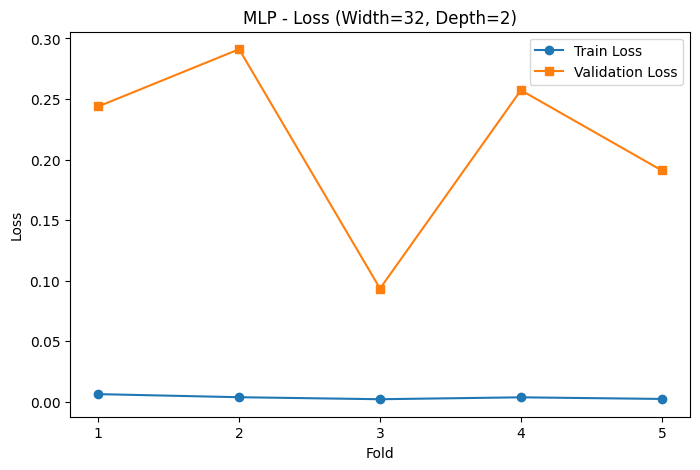

In [21]:
def plot_loss(losses, model_name, best_width, best_depth):
    filtered = [(val, train) for (w, d, val, train) in losses if w == best_width and d == best_depth]

    val_losses = [val for (val, train) in filtered]
    train_losses = [train for (val, train) in filtered]
    folds = range(1, len(val_losses)+1)

    plt.figure(figsize=(8, 5))
    plt.plot(folds, train_losses, label='Train Loss', marker='o')
    plt.plot(folds, val_losses, label='Validation Loss', marker='s')
    plt.title(f'{model_name} - Loss (Width={best_width}, Depth={best_depth})')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.xticks(folds)
    plt.legend()
    plt.show()

plot_loss(final_mlp_loss_list, 'MLP', best_mlp_width, best_mlp_depth)

In [13]:
# SVM

svm = GridSearchCV(
    estimator=SVC(kernel='linear'),
    param_grid={'C': [0.1,1]}, # C param
    cv=5,
    scoring='accuracy',
    verbose=0
)

svm.fit(X_train, y_train)

print("Best parameter:", svm.best_params_)
print(f"\nAccuracy for best model: {svm.best_score_}\n")

best_svm_model = svm.best_estimator_
y_pred = best_svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameter: {'C': 1}

Accuracy for best model: 0.9764518629242097

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       954
           1       0.95      0.90      0.93       161

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [14]:
# Random Forest

rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid={
    'n_estimators': [100, 500],
    'max_depth': [5, 10]
    },
    cv=5,
    scoring='accuracy',
    verbose=0
)

rf.fit(X_train, y_train)

print("Best parameters:", rf.best_params_)
print(f"\nAccuracy for best model: {rf.best_score_}\n")

best_rf_model = rf.best_estimator_
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters: {'max_depth': 10, 'n_estimators': 100}

Accuracy for best model: 0.9264400356328608

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       954
           1       1.00      0.43      0.60       161

    accuracy                           0.92      1115
   macro avg       0.96      0.71      0.78      1115
weighted avg       0.92      0.92      0.90      1115



In [15]:
# Decision Tree

dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid={'max_depth': [5, 10]},
    cv=5,
    scoring='accuracy',
    verbose=0
)

dt.fit(X_train, y_train)

print("Best parameter:", dt.best_params_)
print(f"\nAccuracy for best model: {dt.best_score_}\n")

best_dt_model = dt.best_estimator_
y_pred = best_dt_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameter: {'max_depth': 10}

Accuracy for best model: 0.9432589472200832

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       954
           1       0.95      0.70      0.81       161

    accuracy                           0.95      1115
   macro avg       0.95      0.85      0.89      1115
weighted avg       0.95      0.95      0.95      1115

